# Introduction

The ultimate goal of the project is to show that we can efficiently and accurately compute the electron density maps for our protein of interest under the oscillating EF from MD simulation that could be directly compared to the map obtained from our novel diffraction setup. Hence, finally, in this notebook we will assess convergence of our computed maps using four approaches:

1. Internal difference map (symmetry related pairs of chains),

2. Ordinary difference map (+ve, -ve phases of EF),

3. Structure factors (reciprocal space),

4. Structure from refinement (direct space).

It should be assumed that whenever we can compute a quantity using some subtrajectory, we will compute averages of such quantity over increasingly longer subtrajectory from the production runs to check if our estimate converges to some observed/expected value. We now proceed to explain in detail each of these approaches.

# 1. Internal difference map

EGFP is among the most proteins whose crystals have at least one two-fold symmetry axis. We have four EGFP chains, labeled 0-3, in the MD system that at t=0 are pairwise related by rotation by x,y, or z-axes. Thus, for the pairs related by axes perpendicular to the direction of the electric field (in x-direction), we'd expect the difference in the electron density map within each pair to describe how the field perturbs the protein structure. One can do a subtraction in reciprocal space that is equivalent to subtracting average electron density of the molecules. Then we take correlations of the differences between the two pairs to quantify the quality of our averaged electron density map. In the ideal scenario the correlation should be high for the x,y-axis pairs indicating high symmetry.

Note: The concept was first introduced in the EF-X paper, it's similar in spirit to anomalous difference map.

For example, y-axis rotation relates chain pair 0, 1 with 2, 3, so we first compute $\Delta \rho^{01}, \Delta \rho^{23}$ where $\rho$ denotes electron density from the averaged structure factors $\bar{F}^{0\dots 3}$. Then we calculate $|Corr(\Delta \rho^{01}, \Delta \rho^{23})|$ and evaluate the convergence of this quantity. Simiarly we can compute for chain pairs 0,3 and 1,2 which are related by the z-axis. (See [here](https://dictionary.iucr.org/Real-space_correlation_coefficient) for the definition of real-space correlation coefficient in crystallography)

Running the `aggregate.sh` script in this folder will provide the set of difference maps from structure factors averaged over 5 replicates and 150 ns of trajectory for each, which we can then use to compute the correlations with the `phenix.get_cc_mtz_mtz` program. We will run the program via shell command and then collect its output.

In [4]:
import subprocess
import numpy as np
import pandas as pd
source_cmd = 'source /n/hekstra_lab/people/ziyuan/egfp/phenix_env.sh'

In [1]:
def int_diff_map_fname(epoch, phase, idx1, idx2):
    idx1, idx2 = (idx2, idx1) if idx2 < idx1 else (idx1, idx2)
    return f'processed_data/aggregate/{epoch}/EF_10MV_cm_diff_{phase}_{idx1}_{idx2}.mtz'

def corr_int_diff(epoch, phase, idx1, idx2, idx3, idx4):
    output = subprocess.run([f"{source_cmd}; phenix.get_cc_mtz_mtz {int_diff_map_fname(epoch, 'pos', idx1, idx2)} {int_diff_map_fname(epoch, 'pos', idx3, idx4)}"], 
                               stdout=subprocess.PIPE, shell=True).stdout.decode('utf-8')
    return float(output.split('\n')[-11].split(' ')[3])

In [2]:
idx_lst = [((0,1),(2,3)), ((0,2),(1,3)), ((0,3), (1,2))]
epoch_lst = [30, 60, 90, 120, 150]

df = np.zeros((len(epoch_lst), len(idx_lst)))
for i, idx_tupl in enumerate(idx_lst):
    (idx1, idx2), (idx3, idx4) = idx_tupl
    for j, epoch in enumerate(epoch_lst):
        df[j, i] = corr_int_diff(epoch, 'pos', idx1, idx2, idx3, idx4)

df = pd.DataFrame(df, columns=idx_lst, index=epoch_lst)

In [3]:
df

,"((0, 1), (2, 3))","((0, 2), (1, 3))","((0, 3), (1, 2))"
30,0.204451,-0.055536,-0.254739
60,0.207855,-0.120324,-0.318786
90,0.178059,-0.184358,-0.357307
120,0.183165,0.054210,-0.130285
150,0.035335,-0.061246,-0.096415


Note: the first column (0,1), (2,3) corresponds to y-axis rotation-related pairs, the second column for x-axis and the last for z-axis.

Curiously, we see that as we averaged over longer trajectories, the correlation actually goes down. Also, I'd expect the second column to have very small correlation compared to the other two. This is something I can't quite explain.

# 2. Ordinary difference map

While for the internal difference map, we can compute these quantities even if we apply a constant electric field, because the density difference comes from internal pairs of proteins related by symmetry that is broken by the field. In our experiments we use oscillating field with positive and negative phases, and this allow us to compute an additional set of map where the difference computed between phases. To be precise. We can compute $\Delta \rho^{i}_{+, -}$ for each chain $i$ by taking difference of structure factors of that chain in positive and negative phase of the field ($\bar{F}^{i}_{+}, \bar{F}^{i}_{-}$). We can then look at $|Corr(\Delta \rho^{i}_{+, -}, \Delta \rho^{j}_{+, -})|$ for all pairs $i\neq j$, and we expect to see large correlation whose signs are determined by the symmetry relationship between chain $i$ and $j$.  

As before, we will use `phenix.get_cc_mtz_mtz` to compute the correlations between ordinary difference maps computed with `aggregate.py` script.

In [6]:
def ord_diff_map_fname(epoch, idx, phase1, phase2):
    return f'processed_data/aggregate/{epoch}/EF_10MV_cm_diff_{idx}_{phase1}_{phase2}.mtz'

def corr_ord_diff(epoch, idx1, idx2, phase1, phase2):
    output = subprocess.run([f"{source_cmd}; phenix.get_cc_mtz_mtz {ord_diff_map_fname(epoch, idx1, phase1, phase2)} {ord_diff_map_fname(epoch, idx2, phase1, phase2)}"], 
                               stdout=subprocess.PIPE, shell=True).stdout.decode('utf-8')
    return float(output.split('\n')[-11].split(' ')[3])

In [7]:
idx_lst = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
epoch_lst = [30, 60, 90, 120, 150]

df = np.zeros((len(epoch_lst), len(idx_lst)))
for i, idx_tupl in enumerate(idx_lst):
    (idx1, idx2) = idx_tupl
    for j, epoch in enumerate(epoch_lst):
        df[j, i] = corr_ord_diff(epoch, idx1, idx2, 'pos', 'neg')

df = pd.DataFrame(df, columns=idx_lst, index=epoch_lst)

In [8]:
df

,"(0, 1)","(0, 2)","(0, 3)","(1, 2)","(1, 3)","(2, 3)"
30,-0.751143,0.779079,-0.776186,-0.761739,0.781561,-0.785885
60,-0.732472,0.761619,-0.758474,-0.757531,0.755602,-0.751046
90,-0.709868,0.748085,-0.693716,-0.772622,0.743042,-0.716748
120,-0.736832,0.724845,-0.694589,-0.744340,0.720766,-0.713068
150,-0.710978,0.709352,-0.724926,-0.725559,0.702679,-0.717254


|Chain indices for the pair| (0,1) | (0,2) | (0,3) |(1,2)| (1,3) |(2,3)
|:---|---|---|---|---|---|---|
|Rotation symmetry| y-axis | x-axis| z-axis | z-axis | x-axis | y-axis

Although it's not immediately clear why the correlation slightly decreased with longer trajectories, nevertheless, we see that the correlations are obvious and the signs can be explained by the symmetry, i.e., for x-axis related pairs the dipole moment vectors point in the same direction, so the field induced shifts in electron density are positively correlated between pairs. For y- and z-axis related pairs the directions are different, leading to negative correlation.


# 3. Structure factors (reciprocal space)

To a first approximation, the discrete structure factors $F_{hkl}$ in the reciprocal space are related to the continuous and periodic electron density in direct space via a Fourier transform. Since our EGFP crystal has a nontrivial space group, there will be additional pairs of structure factors that should be the same besides the centrosymmetric pairs. Theoretically, for each of the four symmetry operator of our space group P 21 21 21, we can generate a table of pairs of symop-related structure factors and then compute the complex difference for all pairs. Since it's not clear if correlation coefficient is meaningful for structure factors, we just report the average percentage difference between all pairs for the four symops.



In [ ]:
import gemmi
import reciprocalspaceship as rs
from reciprocalspaceship.utils import  to_structurefactor as to_sf

def compare_symops(mtz, n, original_sg=19):
    """
    The function takes a number and returns a dataset that has the x,y,z
    reflection (reciprocal space ASU) joined with the corresponding
    symmetry-related one under the given symop.

    :param mtz: A reciprocalspaceship Dataset
    :param n: the index of symop belonging to a particular space group, refer to ITC for their definitions
    :param original_sg: The space group that the dataset is assumed to come from
    :return: a Dataset including all pairs of reflections related by the specified symop
    """
    ds = mtz.copy()

    # Map P1 reflections to original ASU
    ds.spacegroup = original_sg
    asu = ds.hkl_to_asu()

    # Find common reflections
    common = asu.loc[asu["M/ISYM"] == 1].index.intersection(asu.loc[asu["M/ISYM"] == n].index).sort_values()
    asu = asu.loc[common]
    asu1 = asu.loc[asu["M/ISYM"] == 1].reset_index()
    asu2 = asu.loc[asu["M/ISYM"] == n].reset_index()

    return asu1.merge(asu2, on=["H", "K", "L"], suffixes=(1, 2))

In [ ]:
sg = 19

for i, symop in enumerate(gemmi.find_spacegroup_by_number(sg).operations()):
    pct_diff = []
    for epoch in epoch_lst:
        dataset = rs.read_mtz(f'processed_data/aggregate/{epoch}/EF_10MV_cm_chainwise_zero_subtraj_0_avg.mtz')
        symop_dataset = compare_symops(dataset, i + 1, sg) 
        sf1 = to_sf(symop_dataset['FMODEL1'], symop_dataset['PHIFMODEL1'])
        sf2 = to_sf(symop_dataset['FMODEL2'], symop_dataset['PHIFMODEL2'])
        mag_cdiff = np.abs(sf1-sf2)
        mag_base = np.abs((sf1+sf2)/2)
        pct_diff.append(np.mean(mag_cdiff/mag_base))
    df1 = pd.DataFrame(pct_diff, columns=[symop.triplet()], index=epoch_lst)
    if i == 0: # initialize
        df_pct_diff = df1
    else: # bind
        df_pct_diff = pd.concat([df_pct_diff, df1], axis=1)


Unfortunately, unlike space group P 41 3 2 (219) for the PDZ domain, we do not have additional symmetry in the structure factors, as could be seen from the unique value of the "M/ISYM" (symmetry operation index) series in the transformed dataframe is only 1 (corresponding to the identity operator).

# 4. Structure from refinement (direct space)

Detailed steps be written. But from visual inspection of the final averaged map, we can see that the computed map (light blue) agrees well with the experimental map (red) and refined structure (green sticks). 

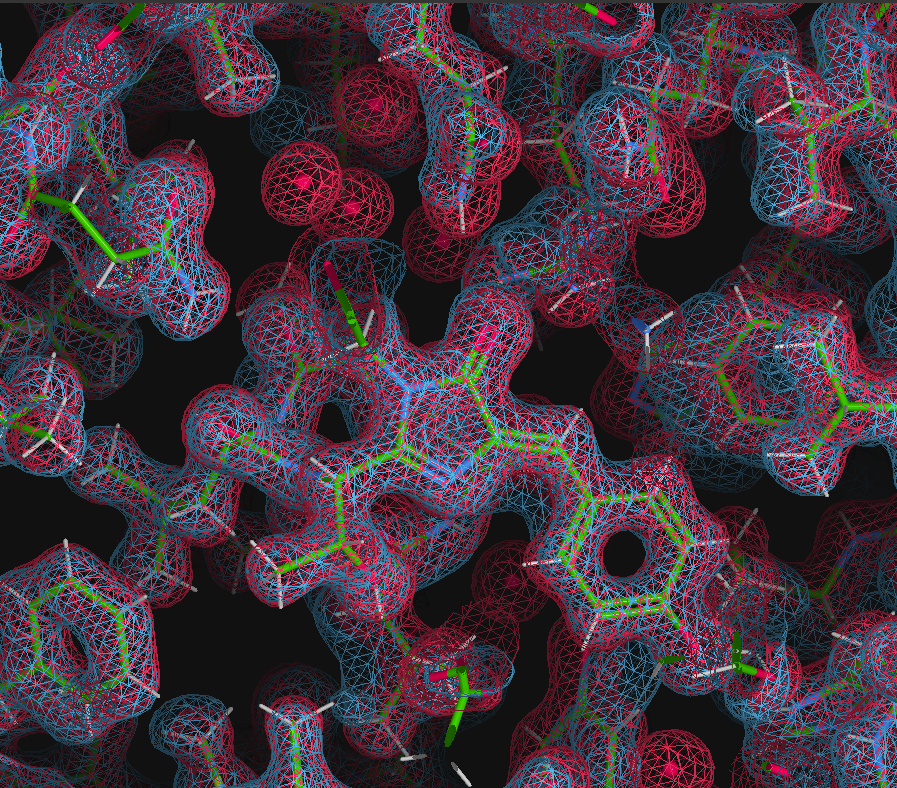